In [ ]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to the input image")
# args = vars(ap.parse_args())
# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


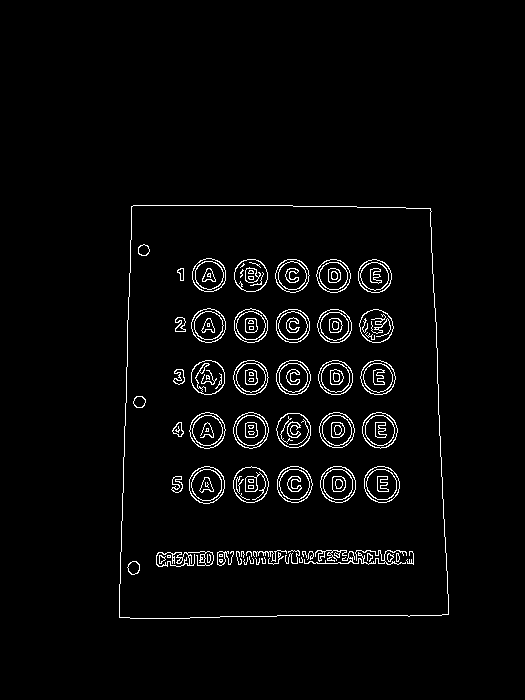

-1

In [ ]:
from google.colab.patches import cv2_imshow

# load the image, convert it to grayscale, blur it
# slightly, then find edges
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/PyImageSearch/omr_test_01.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

cv2_imshow(edged)
cv2.waitKey(0)

In [ ]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)

docCnt = None

if len(cnts) > 0:
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  for c in cnts:
    peri = cv2.arcLength(c, True)

    approx = cv2.approxPolyDP(c,0.02 * peri, True)

    if len(approx) == 4:
      docCnt = approx
      break

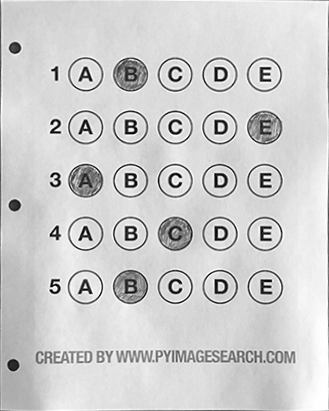

-1

In [ ]:
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

cv2_imshow(warped)
cv2.waitKey(0)

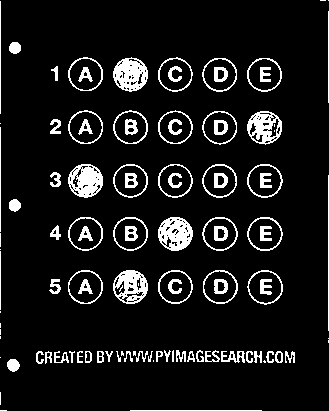

-1

In [ ]:
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

cv2_imshow(thresh)
cv2.waitKey(0)

In [ ]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour, then use the
	# bounding box to derive the aspect ratio
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)
	# in order to label the contour as a question, region
	# should be sufficiently wide, sufficiently tall, and
	# have an aspect ratio approximately equal to 1
	if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
		questionCnts.append(c)
  
len(questionCnts)

25

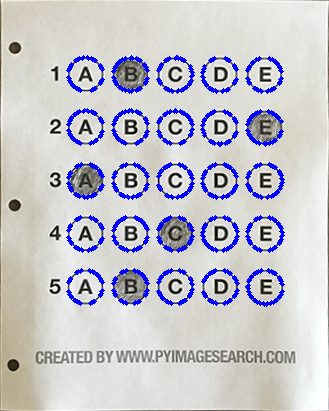

-1

In [ ]:
output = paper.copy()

for c in questionCnts:
  cv2.drawContours(output, c, -1, (255, 0, 0), 3)

cv2_imshow(output)
cv2.waitKey(0)

In [ ]:
# sort the question contours top-to-bottom, then initialize
# the total number of correct answers
questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0

# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
	# sort the contours for the current question from
	# left to right, then initialize the index of the
	# bubbled answer
	cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
  bubbled = None

  for (j, c) in enumerate(cnts):
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    # apply the mask to the thresholded image, then
    # count the number of non-zero pixels in the
    # bubble area
    mask = cv2.bitwise_and(thresh, thresh, mask=mask)
    total = cv2.countNonZero(mask)
    # if the current total has a larger number of total
    # non-zero pixels, then we are examining the currently
    # bubbled-in answer
    if bubbled is None or total > bubbled[0]:
      bubbled = (total, j)

IndentationError: ignored

In [ ]:
  # initialize the contour color and the index of the
  # *correct* answer
  color = (0, 0, 255)
  k = ANSWER_KEY[q]
  print(k)
  # check to see if the bubbled answer is correct
  if k == bubbled[1]:
    color = (0, 255, 0)
    correct += 1
  # draw the outline of the correct answer on the test
  cv2.drawContours(paper, [cnts[k]], -1, color, 3)

1


array([[[134, 157, 170],
        [228, 249, 250],
        [217, 239, 243],
        ...,
        [144, 157, 166],
        [152, 162, 169],
        [129, 139, 144]],

       [[121, 143, 153],
        [222, 240, 243],
        [216, 235, 238],
        ...,
        [241, 243, 244],
        [245, 246, 247],
        [237, 240, 239]],

       [[103, 125, 133],
        [206, 225, 231],
        [204, 221, 226],
        ...,
        [247, 249, 248],
        [253, 254, 254],
        [230, 235, 234]],

       ...,

       [[140, 164, 176],
        [174, 201, 213],
        [156, 182, 194],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [198, 196, 196]],

       [[157, 181, 193],
        [191, 219, 231],
        [173, 201, 212],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [230, 226, 229]],

       [[ 90, 110, 123],
        [120, 140, 156],
        [111, 131, 145],
        ...,
        [206, 200, 202],
        [202, 198, 202],
        [179, 176, 181]]

[INFO] score: 20.00%


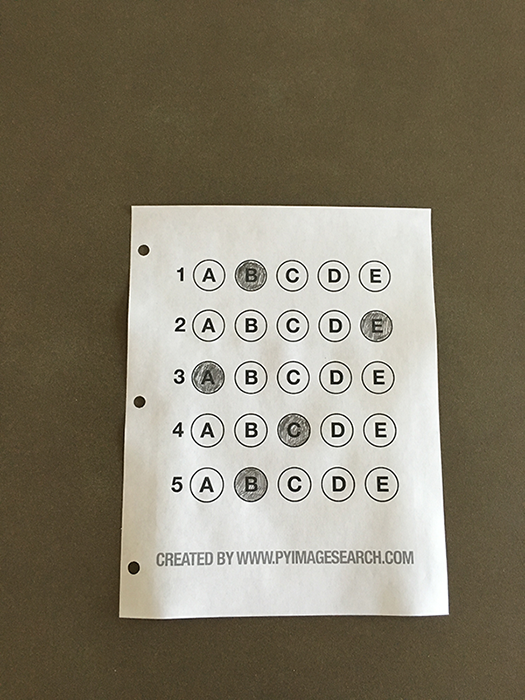

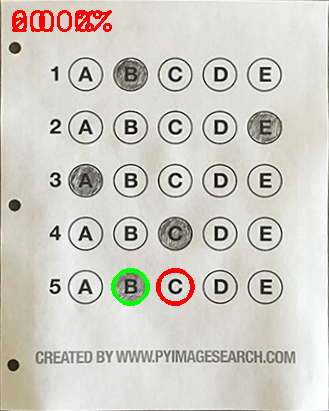

-1

In [ ]:
# grab the test taker
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
	cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2_imshow(image)
cv2_imshow(paper)
cv2.waitKey(0)